# Monitoring COVID-19 Infections through Wastewater Surveillance

## CMPSC 190DD Data Science Capstone Project - Part 1

Helen Huang, ziyihuang@ucsb.edu \
Achyuth Varma, achyuth@ucsb.edu \
Kevin Villanueva, kevin_villanueva@ucsb.edu

In [1]:
# imports
import numpy as np
import scipy
from scipy import integrate
from itertools import product
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
%matplotlib inline

### Part 1A

In [2]:
# load data provided
data = np.load('part1a.npz')

N = data['N']
Svc_0_pmf = data['Svc_0_pmf']
Lc = data['Lc']
Ic_0 = data['Ic_0']
gamma = data['gamma']

#print(N, Svc_0_pmf, Lc, Ic_0, gamma)

In [3]:
# Create arbitary beta values

betas = np.array([0.1, 0.2, 0.3, 0.4, 0.2, 0.3, 0.4, 0.5, 0.3, 0.4, 0.5, 0.6, 0.4, 0.5, 0.6, 0.7])
#print(betas)

#### Question 1

In [4]:
def SIR_model(t, Y, betas, gamma):
  """
  ODE System for SIR Model
  Returns a 21 element numpy array
  """

  """
  Input Y: 21-element vector
  index 0-15: S values (S0_0, S0_1, ... S4_4)
  index 16-19: I values (I0, I1, I2, I3)
  index 20: R value
  """

  S_vector = Y[:16]
  I_vector = Y[16:20]
  R = Y[20]

  """
  [
   # S_vector (S_v_c)
   dS0_0/dt (0), dS0_1/dt (1), dS0_2/dt (2), dS0_3/dt (3),
   dS1_0/dt (4), dS1_1/dt (5), dS1_2/dt (6), dS1_3/dt (7),
   dS2_0/dt (8), dS2_1/dt (9), dS2_2/dt (10), dS2_3/dt (11),
   dS3_0/dt (12), dS3_1/dt (13), dS3_2/dt (14), dS3_3/dt (15),

   # I_vector
   dI0dt (0), dI1dt (1), dI2dt (2), dI3dt (3),

   # R_vector
   R(0)
  ]
  """

  # betas: 16 element

  # dS_dt: 16 element
  dS_dt = []
  for i in range(16):
    dS_v_cdt = (-(betas[i] * S_vector[i] * np.sum(I_vector)) / N)
    dS_dt.append(dS_v_cdt)
  
  # dIdt: 4 element
  dI_dt = []
  for i in range(4):
    # Calculate summation dSdt
    sum = 0
    # v(i)=0,1,2,3, c(j)=0
    for j in range(4):
      sum += dS_dt[j*4 + i]

    dIc_dt = -sum - gamma * I_vector[i]
    dI_dt.append(dIc_dt)

  # dRdt: 1 element
  dR_dt = [gamma * np.sum(I_vector)]

  # RHS: 21 element
  RHS = np.array(dS_dt + dI_dt + dR_dt)
  
  return RHS

In [5]:
# Initial Values: 21 values

# Subtracting the initial infected population Ic_0 from N
for i in range(4):
    Svc_0_pmf[:, i] = Svc_0_pmf[:, i] * (N - Ic_0[i])

Svc_0_pmf = Svc_0_pmf.reshape((1,16))
Ic_0 = Ic_0.reshape((1,4))
R_0 = np.array([0])

SIR_initial = np.concatenate((Svc_0_pmf, Ic_0, R_0), axis = None)

#print(SIR_initial)

In [6]:
# Solve ODE, simulate for 120 days

#tspan = (0, 120)
t = np.linspace(0, 119, 120)
sol = integrate.solve_ivp(SIR_model, (t[0], t[-1]), SIR_initial, args=(betas,gamma))

#print(sol.y)

#### Question 2

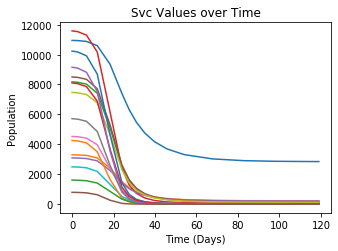

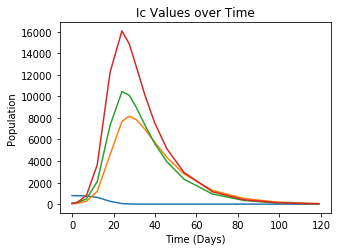

In [7]:
# Visualization

# S_v_c plots
plt.figure(figsize=(4.8, 3.6))
for i in range(16):
  plt.plot(sol.t, sol.y[i])
plt.title("Svc Values over Time")
plt.xlabel("Time (Days)")
plt.ylabel("Population")
plt.tight_layout()
plt.show()

# I_c plots
plt.figure(figsize=(4.8, 3.6))
for i in range(4):
  plt.plot(sol.t, sol.y[15 + i])
plt.title("Ic Values over Time")
plt.xlabel("Time (Days)")
plt.ylabel("Population")
plt.tight_layout()
plt.show()

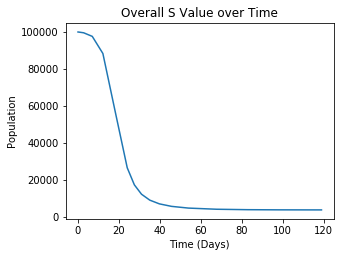

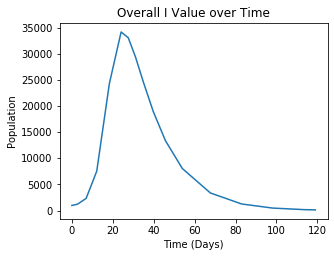

In [8]:
# Overall S & R plot

# S
plt.figure(figsize=(4.8, 3.6))
overallS = 0
for i in range(16):
  overallS += sol.y[i]

plt.plot(sol.t, overallS)
plt.title("Overall S Value over Time")
plt.xlabel("Time (Days)")
plt.ylabel("Population")
plt.show()

# I
plt.figure(figsize=(4.8, 3.6))
overallI = 0
for i in range(4):
  overallI += sol.y[15 + i]

plt.plot(sol.t, overallI)
plt.title("Overall I Value over Time")
plt.xlabel("Time (Days)")
plt.ylabel("Population")
plt.show()

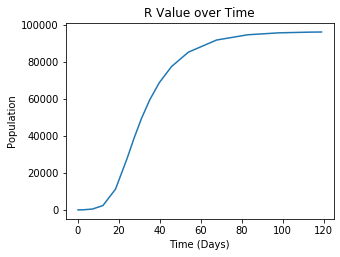

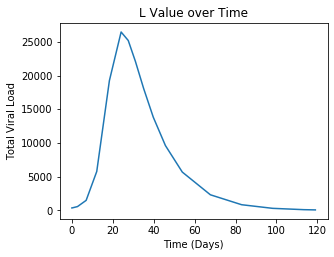

In [9]:
# R plot
plt.figure(figsize=(4.8, 3.6))
plt.plot(sol.t, sol.y[20])
plt.title("R Value over Time")
plt.xlabel("Time (Days)")
plt.ylabel("Population")
plt.show()

# L plot
# Viral load L
"""
L = I_0 * L_0 + I_1 * L_1 + I_2 * L_2 + I_3 * L_3
I changes over time, so L chanegs over time
"""
plt.figure(figsize=(4.8, 3.6))
L = sol.y[15]*Lc[0] + sol.y[16]*Lc[1] + sol.y[17]*Lc[2] + sol.y[18]*Lc[3]
plt.plot(sol.t, L)
plt.title("L Value over Time")
plt.xlabel("Time (Days)")
plt.ylabel("Total Viral Load")
plt.show()

#### Question 3

Yes, the shapes of S, I, R look similar to what we expected. S looks like a decreasing sigmoid function over time. I is increasing during the early time because more people are exposed to the disease and is decreasing later because more people recovered. R is an increasing sigmoid function over time.

I is the curve when people refer to when they say "flatten the curve" because we want to limit the maximum amount of people being infected at the same time.

#### Question 4

Yes, some S_v_c compartments converged to zero while one of them convered to a positive value.

It is converting to a positive value because some people never got infected and the rest got recovered before they had a chance of infection.

#### Question 5

In [10]:
# Percentage of the whole population that are never infected

no_infected_all = 0
for i in range(16):
  no_infected_all += (sol.y[i][-1])

print("Percentages of population that never got infected: ", no_infected_all / N * 100, "%")

Percentages of population that never got infected:  3.827983924248656 %


#### Question 6

In [11]:
# Multiply all the betas by 1/4 and simulate again

tspan = (0, 120)
sol2 = integrate.solve_ivp(SIR_model, tspan, SIR_initial, args=(betas/4,gamma))

#print(sol2.y)

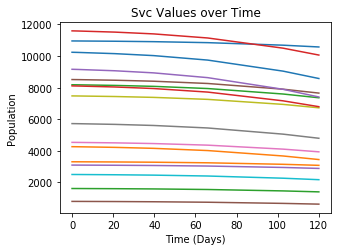

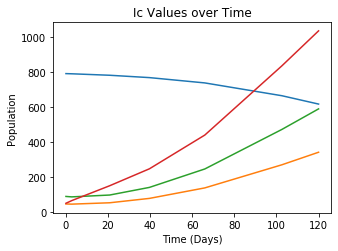

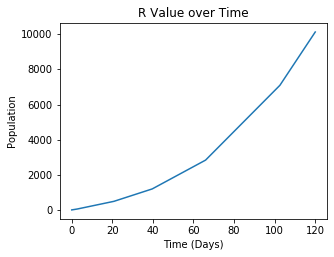

In [12]:
# New Visulization

# S_v_c plots
plt.figure(figsize=(4.8, 3.6))
for i in range(16):
  plt.plot(sol2.t, sol2.y[i])
plt.title("Svc Values over Time")
plt.xlabel("Time (Days)")
plt.ylabel("Population")
plt.tight_layout()
plt.show()

# I_c plots
plt.figure(figsize=(4.8, 3.6))
for i in range(4):
  plt.plot(sol2.t, sol2.y[15 + i])
plt.title("Ic Values over Time")
plt.xlabel("Time (Days)")
plt.ylabel("Population")
plt.tight_layout()
plt.show()

# R plot
plt.figure(figsize=(4.8, 3.6))
plt.plot(sol2.t, sol2.y[20])
plt.title("R Value over Time")
plt.xlabel("Time (Days)")
plt.ylabel("Population")
plt.show()

Yes, the curves flatten a lot compared to the previous case.

In [13]:
# New percentage of the whole population that are never infected

no_infected_all2 = 0
for i in range(16):
  no_infected_all2 += sol2.y[i][-1]

print("Percentages of population that never got infected given the new beta values: ", no_infected_all2 / N * 100, "%")

Percentages of population that never got infected given the new beta values:  87.36438288886697 %


### Part 1B

In [14]:
# load data provided
data = np.load('part1b.npz')

#print(data.files)

N = data['N']
Lc = data['Lc']
Ic_0 = data['Ic_0']
gamma = data['gamma']
L_validation = data['L_validation']
L_test = data['L_test']
betas_validation = data['betas_validation']

# L_validation: 20 (nodes) x 20 (days)
# 4 different v groups, each has 5 nodes
# 0-4: v = 0.2
# 5-9: v = 0.4
# 10-14: v = 0.6
# 15-19: v = 0.8

#### Question 1

In [15]:
def SIR_model_B(t, Y, betas, gamma):
  """
  ODE System for modified SIR Model for part 1b
  Returns a 9 element numpy array
  """

  """
  Input Y: 9-element vector
  index 0-3: S values (Sx_0, Sx_1, Sx_2, Sx_3)
  index 4-7: I values (I0, I1, I2, I3)
  index 9: R value
  """

  S_vector = Y[:4]
  I_vector = Y[4:8]
  R = Y[8]

  """
  [
   # S_vector (S_v_c)
   dSv_0/dt (0), dSv_1/dt (1), dSv_2/dt (2), dSv_3/dt (3),

   # I_vector
   dI0dt (0), dI1dt (1), dI2dt (2), dI3dt (3),

   # R_vector
   R(0)
  """

  # betas: 4 element

  # dS_dt: 4 element
  dS_dt = []
  for i in range(4):
    dS_v_cdt = (-(betas[i] * S_vector[i] * np.sum(I_vector)) / N)
    dS_dt.append(dS_v_cdt)
  
  # dIdt: 4 element
  dI_dt = []
  for i in range(4):
    dIc_dt = -1 * dS_dt[i] - gamma * I_vector[i]
    dI_dt.append(dIc_dt)

  # dRdt: 1 element
  dR_dt = [gamma * np.sum(I_vector)]

  # RHS: 9 element
  RHS = np.array(dS_dt + dI_dt + dR_dt)
  
  return RHS

In [16]:
# Initial Values: S

# Subtracting the initial infected population Ic_0 from N
S_0_v0 = np.outer(N - (Ic_0[0:5]).sum(axis = 1),(0.5, 0.3, 0.1, 0.1))
S_0_v1 = np.outer(N - (Ic_0[5:10]).sum(axis = 1),(0.4, 0.3, 0.2, 0.1)) 
S_0_v2 = np.outer(N - (Ic_0[10:15]).sum(axis = 1),(0.3, 0.3, 0.2, 0.2)) 
S_0_v3 = np.outer(N - (Ic_0[15:20]).sum(axis = 1),(0.1, 0.2, 0.3, 0.4))

R_0 = np.array([0])

#print(S_0_v0)
#print(S_0_v1)
#print(S_0_v2)
#print(S_0_v3)

In [17]:
# Set up beta grind
beta_grind = np.linspace(0, 1, 21)

# Set up time
t = np.linspace(0, 19, 20)

In [18]:
# 1st v group, v = 0.2

mmse_v0 = np.inf
betas_mmse_v0 = None

for b1, b2, b3, b4 in product(beta_grind, beta_grind, beta_grind, beta_grind):

  # Check if beta is increasing
  if b1 < b2 < b3 < b4:
    betas = np.array([b1, b2, b3, b4])

    # mse for 1st v group
    mse_v0 = 0

    for i in range(5):
      SIR_initial = np.concatenate((S_0_v0[i], Ic_0[i], R_0), axis = None)
      sol = integrate.solve_ivp(SIR_model_B, (t[0], t[-1]), SIR_initial, t_eval = t, args=(betas,gamma))

      L_predicted = sol.y[4]*Lc[0] + sol.y[5]*Lc[1] + sol.y[6]*Lc[2] + sol.y[7]*Lc[3]
      mse_v0 += mean_squared_error(L_validation[i], L_predicted)

    if mse_v0 < mmse_v0:
      mmse_v0 = mse_v0
      betas_mmse_v0 = betas

print(mmse_v0)
print(betas_mmse_v0)

23.712624182372426
[0.1  0.15 0.2  0.25]


In [19]:
# 2nd v group, v = 0.4

mmse_v1 = np.inf
betas_mmse_v1 = None

for b1, b2, b3, b4 in product(beta_grind, beta_grind, beta_grind, beta_grind):

  # Check if beta is increasing
  if b1 < b2 < b3 < b4:
    betas = np.array([b1, b2, b3, b4])

    # mse for 1st v group
    mse_v1 = 0

    for i in range(5):
      SIR_initial = np.concatenate((S_0_v1[i], Ic_0[i + 5], R_0), axis = None)
      sol = integrate.solve_ivp(SIR_model_B, (t[0], t[-1]), SIR_initial, t_eval = t, args=(betas,gamma))

      L_predicted = sol.y[4]*Lc[0] + sol.y[5]*Lc[1] + sol.y[6]*Lc[2] + sol.y[7]*Lc[3]
      mse_v1 += mean_squared_error(L_validation[i + 5], L_predicted)

    if mse_v1 < mmse_v1:
      mmse_v1 = mse_v1
      betas_mmse_v1 = betas

print(mmse_v1)
print(betas_mmse_v1)

640.5563821300137
[0.2  0.25 0.3  0.4 ]


In [20]:
# 3rd v group, v = 0.6

mmse_v2 = np.inf
betas_mmse_v2 = None

for b1, b2, b3, b4 in product(beta_grind, beta_grind, beta_grind, beta_grind):

  # Check if beta is increasing
  if b1 < b2 < b3 < b4:
    betas = np.array([b1, b2, b3, b4])

    # mse for 1st v group
    mse_v2 = 0

    for i in range(5):
      SIR_initial = np.concatenate((S_0_v2[i], Ic_0[i + 10], R_0), axis = None)
      sol = integrate.solve_ivp(SIR_model_B, (t[0], t[-1]), SIR_initial, t_eval = t, args=(betas,gamma))

      L_predicted = sol.y[4]*Lc[0] + sol.y[5]*Lc[1] + sol.y[6]*Lc[2] + sol.y[7]*Lc[3]
      mse_v2 += mean_squared_error(L_validation[i + 10], L_predicted)

    if mse_v2 < mmse_v2:
      mmse_v2 = mse_v2
      betas_mmse_v2 = betas

print(mmse_v2)
print(betas_mmse_v2)

33587.87126700872
[0.35 0.45 0.5  0.6 ]


In [21]:
# 4th v group, v = 0.8

mmse_v3 = np.inf
betas_mmse_v3 = None

for b1, b2, b3, b4 in product(beta_grind, beta_grind, beta_grind, beta_grind):

  # Check if beta is increasing
  if b1 < b2 < b3 < b4:
    betas = np.array([b1, b2, b3, b4])

    # mse for 1st v group
    mse_v3 = 0

    for i in range(5):
      SIR_initial = np.concatenate((S_0_v3[i], Ic_0[i + 15], R_0), axis = None)
      sol = integrate.solve_ivp(SIR_model_B, (t[0], t[-1]), SIR_initial, t_eval = t, args=(betas,gamma))

      L_predicted = sol.y[4]*Lc[0] + sol.y[5]*Lc[1] + sol.y[6]*Lc[2] + sol.y[7]*Lc[3]
      mse_v3 += mean_squared_error(L_validation[i + 15], L_predicted)

    if mse_v3 < mmse_v3:
      mmse_v3 = mse_v3
      betas_mmse_v3 = betas

print(mmse_v3)
print(betas_mmse_v3)

108784.7003052942
[0.4 0.5 0.6 0.8]


In [22]:
# Compare the beta estimated with the ground truth
print("Ground truth betas:\n", betas_validation)

print("\nEstimated betas:")
print(betas_mmse_v0)
print(betas_mmse_v1)
print(betas_mmse_v2)
print(betas_mmse_v3)

Ground truth betas:
 [[0.1  0.15 0.2  0.25]
 [0.2  0.25 0.3  0.4 ]
 [0.35 0.45 0.5  0.6 ]
 [0.4  0.5  0.6  0.8 ]]

Estimated betas:
[0.1  0.15 0.2  0.25]
[0.2  0.25 0.3  0.4 ]
[0.35 0.45 0.5  0.6 ]
[0.4 0.5 0.6 0.8]


#### Question 2

In [23]:
# 1st v group, v = 0.2

mmse_v0 = np.inf
betas_mmse_v0 = None

for b1, b2, b3, b4 in product(beta_grind, beta_grind, beta_grind, beta_grind):

  # Check if beta is increasing
  if b1 < b2 < b3 < b4:
    betas = np.array([b1, b2, b3, b4])

    # mse for 1st v group
    mse_v0 = 0

    for i in range(5):
      SIR_initial = np.concatenate((S_0_v0[i], Ic_0[i], R_0), axis = None)
      sol = integrate.solve_ivp(SIR_model_B, (t[0], t[-1]), SIR_initial, t_eval = t, args=(betas,gamma))

      L_predicted = sol.y[4]*Lc[0] + sol.y[5]*Lc[1] + sol.y[6]*Lc[2] + sol.y[7]*Lc[3]
      mse_v0 += mean_squared_error(L_test[i], L_predicted)

    if mse_v0 < mmse_v0:
      mmse_v0 = mse_v0
      betas_mmse_v0 = betas

print(mmse_v0)
print(betas_mmse_v0)

12.06739176066739
[0.05 0.1  0.15 0.25]


In [24]:
# 2nd v group, v = 0.4

mmse_v1 = np.inf
betas_mmse_v1 = None

for b1, b2, b3, b4 in product(beta_grind, beta_grind, beta_grind, beta_grind):

  # Check if beta is increasing
  if b1 < b2 < b3 < b4:
    betas = np.array([b1, b2, b3, b4])

    # mse for 1st v group
    mse_v1 = 0

    for i in range(5):
      SIR_initial = np.concatenate((S_0_v1[i], Ic_0[i + 5], R_0), axis = None)
      sol = integrate.solve_ivp(SIR_model_B, (t[0], t[-1]), SIR_initial, t_eval = t, args=(betas,gamma))

      L_predicted = sol.y[4]*Lc[0] + sol.y[5]*Lc[1] + sol.y[6]*Lc[2] + sol.y[7]*Lc[3]
      mse_v1 += mean_squared_error(L_test[i + 5], L_predicted)

    if mse_v1 < mmse_v1:
      mmse_v1 = mse_v1
      betas_mmse_v1 = betas

print(mmse_v1)
print(betas_mmse_v1)

835.5508455930113
[0.2  0.25 0.3  0.4 ]


In [25]:
# 3rd v group, v = 0.6

mmse_v2 = np.inf
betas_mmse_v2 = None

for b1, b2, b3, b4 in product(beta_grind, beta_grind, beta_grind, beta_grind):

  # Check if beta is increasing
  if b1 < b2 < b3 < b4:
    betas = np.array([b1, b2, b3, b4])

    # mse for 1st v group
    mse_v2 = 0

    for i in range(5):
      SIR_initial = np.concatenate((S_0_v2[i], Ic_0[i + 10], R_0), axis = None)
      sol = integrate.solve_ivp(SIR_model_B, (t[0], t[-1]), SIR_initial, t_eval = t, args=(betas,gamma))

      L_predicted = sol.y[4]*Lc[0] + sol.y[5]*Lc[1] + sol.y[6]*Lc[2] + sol.y[7]*Lc[3]
      mse_v2 += mean_squared_error(L_test[i + 10], L_predicted)

    if mse_v2 < mmse_v2:
      mmse_v2 = mse_v2
      betas_mmse_v2 = betas

print(mmse_v2)
print(betas_mmse_v2)

49661.00889067097
[0.4  0.45 0.5  0.6 ]


In [26]:
# 4th v group, v = 0.8

mmse_v3 = np.inf
betas_mmse_v3 = None

for b1, b2, b3, b4 in product(beta_grind, beta_grind, beta_grind, beta_grind):

  # Check if beta is increasing
  if b1 < b2 < b3 < b4:
    betas = np.array([b1, b2, b3, b4])

    # mse for 1st v group
    mse_v3 = 0

    for i in range(5):
      SIR_initial = np.concatenate((S_0_v3[i], Ic_0[i + 15], R_0), axis = None)
      sol = integrate.solve_ivp(SIR_model_B, (t[0], t[-1]), SIR_initial, t_eval = t, args=(betas,gamma))

      L_predicted = sol.y[4]*Lc[0] + sol.y[5]*Lc[1] + sol.y[6]*Lc[2] + sol.y[7]*Lc[3]
      mse_v3 += mean_squared_error(L_test[i + 15], L_predicted)

    if mse_v3 < mmse_v3:
      mmse_v3 = mse_v3
      betas_mmse_v3 = betas

print(mmse_v3)
print(betas_mmse_v3)

120947.25317227856
[0.45 0.65 0.75 0.85]


In [27]:
# Print all 16 beta values

print("\nEstimated betas:\n")
print(betas_mmse_v0)
print(betas_mmse_v1)
print(betas_mmse_v2)
print(betas_mmse_v3)


Estimated betas:

[0.05 0.1  0.15 0.25]
[0.2  0.25 0.3  0.4 ]
[0.4  0.45 0.5  0.6 ]
[0.45 0.65 0.75 0.85]


#### Question 3

In [28]:
# 100 days for first node of v = 0.2

t = np.linspace(0, 99, 100)

SIR_initial = np.concatenate((S_0_v0[0], Ic_0[0], R_0), axis = None)

sol = integrate.solve_ivp(SIR_model_B, (t[0], t[-1]), SIR_initial, t_eval = t, args=(betas_mmse_v0,gamma))

#print(sol.y)

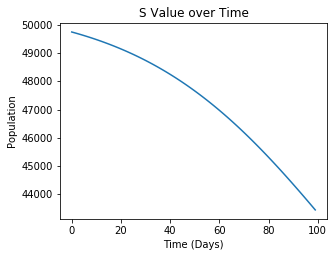

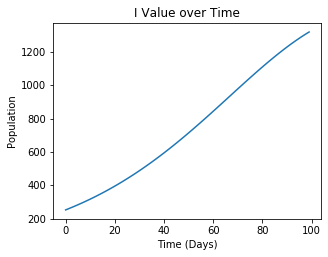

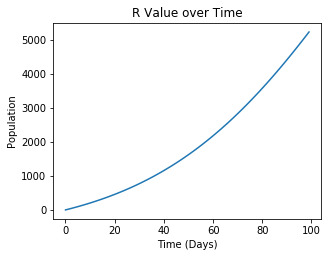

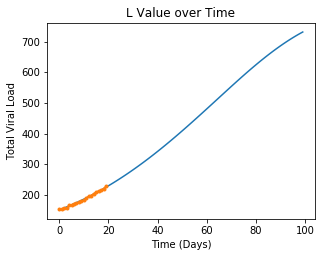

In [29]:
# S
plt.figure(figsize=(4.8, 3.6))
overallS = 0
for i in range(4):
  overallS += sol.y[i]

plt.plot(sol.t, overallS)
plt.title("S Value over Time")
plt.xlabel("Time (Days)")
plt.ylabel("Population")
plt.show()

# I
plt.figure(figsize=(4.8, 3.6))
overallI = 0
for i in range(4):
  overallI += sol.y[4 + i]

plt.plot(sol.t, overallI)
plt.title("I Value over Time")
plt.xlabel("Time (Days)")
plt.ylabel("Population")
plt.show()

# R plot
plt.figure(figsize=(4.8, 3.6))
plt.plot(sol.t, sol.y[8])
plt.title("R Value over Time")
plt.xlabel("Time (Days)")
plt.ylabel("Population")
plt.show()

# L plot
# Viral load L
plt.figure(figsize=(4.8, 3.6))
L = sol.y[4]*Lc[0] + sol.y[5]*Lc[1] + sol.y[6]*Lc[2] + sol.y[7]*Lc[3]
plt.plot(sol.t, L)
# Observed Value for the first 20 days (L_test)
plt.plot(np.linspace(0, 19, 20), L_test[0], marker = '.')
plt.title("L Value over Time")
plt.xlabel("Time (Days)")
plt.ylabel("Total Viral Load")
plt.show()

In [30]:
# 100 days for first node of v = 0.4

t = np.linspace(0, 99, 100)

SIR_initial = np.concatenate((S_0_v1[0], Ic_0[5], R_0), axis = None)

sol = integrate.solve_ivp(SIR_model_B, (t[0], t[-1]), SIR_initial, t_eval = t, args=(betas_mmse_v1,gamma))

#print(sol.y)

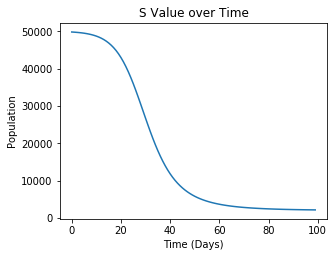

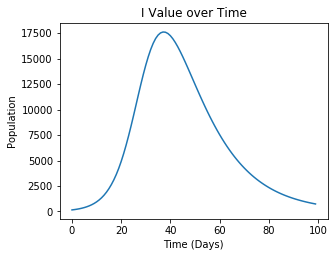

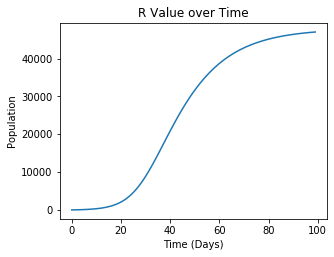

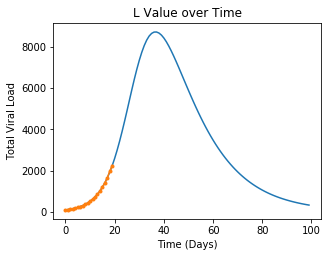

In [31]:
# S
plt.figure(figsize=(4.8, 3.6))
overallS = 0
for i in range(4):
  overallS += sol.y[i]

plt.plot(sol.t, overallS)
plt.title("S Value over Time")
plt.xlabel("Time (Days)")
plt.ylabel("Population")
plt.show()

# I
plt.figure(figsize=(4.8, 3.6))
overallI = 0
for i in range(4):
  overallI += sol.y[4 + i]

plt.plot(sol.t, overallI)
plt.title("I Value over Time")
plt.xlabel("Time (Days)")
plt.ylabel("Population")
plt.show()

# R plot
plt.figure(figsize=(4.8, 3.6))
plt.plot(sol.t, sol.y[8])
plt.title("R Value over Time")
plt.xlabel("Time (Days)")
plt.ylabel("Population")
plt.show()

# L plot
# Viral load L
plt.figure(figsize=(4.8, 3.6))
L = sol.y[4]*Lc[0] + sol.y[5]*Lc[1] + sol.y[6]*Lc[2] + sol.y[7]*Lc[3]
plt.plot(sol.t, L)
# Observed Value for the first 20 days (L_test)
plt.plot(np.linspace(0, 19, 20), L_test[5], marker = '.')
plt.title("L Value over Time")
plt.xlabel("Time (Days)")
plt.ylabel("Total Viral Load")
plt.show()

In [32]:
# 100 days for first node of v = 0.6

t = np.linspace(0, 99, 100)

SIR_initial = np.concatenate((S_0_v2[0], Ic_0[10], R_0), axis = None)

sol = integrate.solve_ivp(SIR_model_B, (t[0], t[-1]), SIR_initial, t_eval = t, args=(betas_mmse_v2,gamma))

#print(sol.y)

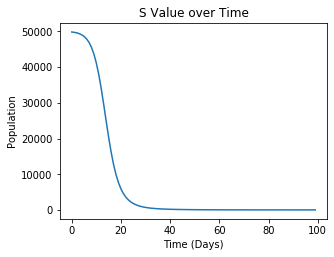

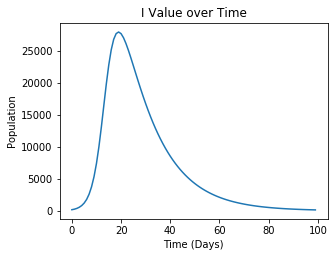

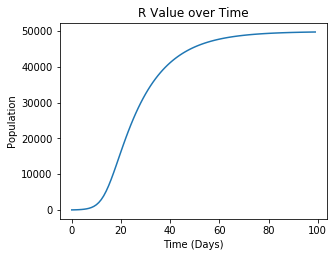

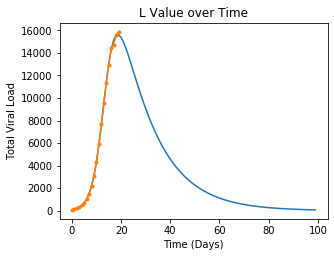

In [33]:
# S
plt.figure(figsize=(4.8, 3.6))
overallS = 0
for i in range(4):
  overallS += sol.y[i]

plt.plot(sol.t, overallS)
plt.title("S Value over Time")
plt.xlabel("Time (Days)")
plt.ylabel("Population")
plt.show()

# I
plt.figure(figsize=(4.8, 3.6))
overallI = 0
for i in range(4):
  overallI += sol.y[4 + i]

plt.plot(sol.t, overallI)
plt.title("I Value over Time")
plt.xlabel("Time (Days)")
plt.ylabel("Population")
plt.show()

# R plot
plt.figure(figsize=(4.8, 3.6))
plt.plot(sol.t, sol.y[8])
plt.title("R Value over Time")
plt.xlabel("Time (Days)")
plt.ylabel("Population")
plt.show()

# L plot
# Viral load L
plt.figure(figsize=(4.8, 3.6))
L = sol.y[4]*Lc[0] + sol.y[5]*Lc[1] + sol.y[6]*Lc[2] + sol.y[7]*Lc[3]
plt.plot(sol.t, L)
# Observed Value for the first 20 days (L_test)
plt.plot(np.linspace(0, 19, 20), L_test[10], marker = '.')
plt.title("L Value over Time")
plt.xlabel("Time (Days)")
plt.ylabel("Total Viral Load")
plt.show()

In [34]:
# 100 days for first node of v = 0.8

t = np.linspace(0, 99, 100)

SIR_initial = np.concatenate((S_0_v3[0], Ic_0[15], R_0), axis = None)

sol = integrate.solve_ivp(SIR_model_B, (t[0], t[-1]), SIR_initial, t_eval = t, args=(betas_mmse_v3,gamma))

#print(sol.y)

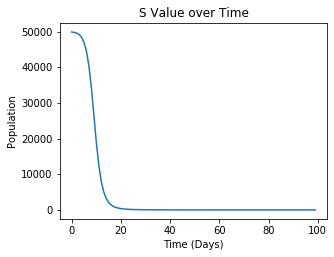

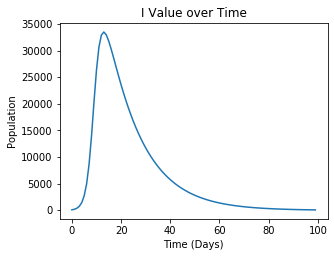

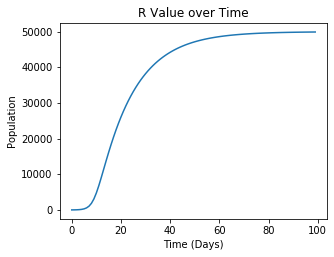

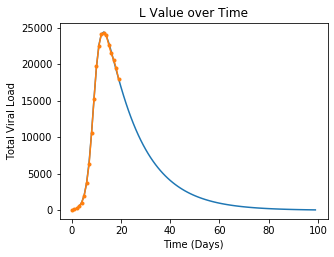

In [35]:
# S
plt.figure(figsize=(4.8, 3.6))
overallS = 0
for i in range(4):
  overallS += sol.y[i]

plt.plot(sol.t, overallS)
plt.title("S Value over Time")
plt.xlabel("Time (Days)")
plt.ylabel("Population")
plt.show()

# I
plt.figure(figsize=(4.8, 3.6))
overallI = 0
for i in range(4):
  overallI += sol.y[4 + i]

plt.plot(sol.t, overallI)
plt.title("I Value over Time")
plt.xlabel("Time (Days)")
plt.ylabel("Population")
plt.show()

# R plot
plt.figure(figsize=(4.8, 3.6))
plt.plot(sol.t, sol.y[8])
plt.title("R Value over Time")
plt.xlabel("Time (Days)")
plt.ylabel("Population")
plt.show()

# L plot
# Viral load L
plt.figure(figsize=(4.8, 3.6))
L = sol.y[4]*Lc[0] + sol.y[5]*Lc[1] + sol.y[6]*Lc[2] + sol.y[7]*Lc[3]
plt.plot(sol.t, L)
# Observed Value for the first 20 days (L_test)
plt.plot(np.linspace(0, 19, 20), L_test[15], marker = '.')
plt.title("L Value over Time")
plt.xlabel("Time (Days)")
plt.ylabel("Total Viral Load")
plt.show()